In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize 
from scipy.optimize import curve_fit
import pandas as pd
import math

In [6]:
# %%
#Defining all functions that will be used in program
def csv_to_np(filename):
    #filemane is a csv of xrd data with the first column being two-theta 
    # and subsequent columns being xray intensities
    data = pd.read_csv(filename)
    return(np.array(data))

def norm(x):
    #returns normalized version of an array
    return x/np.nanmax(x)

def two_to_q(two_theta, wave):
    #two_theta is a 1D array of two_theta angles
    #wave is the X-ray energy in angstroms
    rad_theta = two_theta/2*np.pi/180
    q = 4*np.pi*np.sin(rad_theta)/wave
    return q

def find_nearest(array, value):
    #array is a 1D vector of two_theta or q values
    #value is the specific angle or q for which you want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #limit1 and limit2 are what you'd like to trime your data to 
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2,:]

def back_subtract(x, data, length):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #length is the number of values on the edges of the data you want to use to create a linear background 
    x_linear = np.hstack((x[0:length], x[-length:-1])) #I'm taking the starting and ending values
    data_linear = np.hstack((data[0:length], data[-length:-1])) #We'll use these to fit a straight line
    slope, intercept = np.polyfit(x_linear, data_linear, 1) #Do linear fit
    back = slope*x+intercept 
    data_correct=(data-back)
    return data_correct

def gaussian(x, a, b, c): 
    #generic gaussian curve, for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a*np.exp(-(x - b)**2/(2*c**2))

def normal_gaussian(x, a, b): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the peak position and 
    #b is the FWHM
    return 2/b*sqrt(ln(2)/math.pi)*np.exp(-4*ln(2)/b**2*(x - a)**2)

def two_gaussians(x, a1, b1, c1, a2, b2, c2):
        return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2))

def multi_gaussian(x, guesses):
    #NOTE This function does not work with curve fitting yet TBD
    # x is 1D array of 2-theta or q values for our fitting
    # trips is an array of fits i.e. [[200, 1, .01], [150, 1.05. .02]]
    peaks = [gaussian(x, fit[0], fit[1], fit[2]) for fit in guesses]
    return np.sum(peaks, axis=0)

# Define three peak fitting
def three_gaussians(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    return (gaussian(x, a1, b1, c1) +
            gaussian(x, a2, b2, c2)+ #this would be your initial peak center in Q
            gaussian(x, a3, b3, c3))
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)
    
def mult_pvoigt(x, e, a, b, c, a2, b2, c2, a3, b3, c3):
    return pvoigt(x, e, a, b, c) + pvoigt(x, e, a2, b2, c2) +  pvoigt(x, e, a3, b3, c3) 

def q_to_a(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    a = 2*math.pi*math.sqrt(plane[0]**2+plane[1]**2+plane[2]**2)/center
    return a

def num_files(data):
    #data is the file you are currently analyzing
    #returns columns of data (i.e. frames for XRD data from SSRL)
    size = data.shape
    return size[1]

def q_to_chem(center,plane):
    #center is the center of an xrd peak
    #plane is a list of the formal [h,k,l]
    #takes peak position in q and converts it to bromine percentage
    #using linear fit for bromine fraction on lattice spacing
    slope = -0.3637
    intercept = 6.2841
    br_frac = 1/slope*(q_to_a(center,plane)-intercept)
    return br_frac

def frames_to_time(x,speed,start_lag):
    #x=num_frames
    #speed=shutter speed in s
    #start_lag=t at x=0
    seconds=np.array([(x*speed)+ start_lag])
    return seconds

def perovtopbi2(q, intensity):
    #array is a 1D vector of  q values
    #intensity is a 1D vector of perovskite intensities
    leadiodide_q = 0.9 #rough q of lead iodide peak 
    pad = 10 #number of points around leadiodide_q to look for true max
    peak = find_nearest(q,leadiodide_q)
    leadiodide_inensity = max(intensity[peak-pad:peak+pad])
    ratio = max(intensity)/leadiodide_inensity
    return ratio

In [7]:
# %% Create dictionary for storing analyzed results - to be run at the start of a new session
samplelist = []
results = {"Sample":"Results"}

In [8]:
#%% Import Data
samplename = 'lighton_c1'
perov_import = csv_to_np('/Users/grace/Desktop/wellesley solar/' + samplename + '.csv')
light_on = 1 # if light on set to 1 else set to 0
interval = 2 # time interval between frames in minutes


In [9]:
# Covert to Q
q = two_to_q(perov_import[:,0],0.982381)
perov = perov_import[:,1:] #seperate XRD intensities from rest of data 


In [10]:
# Trim and Remove Background
miller = [2, 0, 0] #peak you are trying to capture
q_1 = 1.92 #lower limit in q
q_2 = 2.18 # upper limit in q 
q_sub, perov_sub = trim_data(q,perov,q_1,q_2)
perov_fit = perov_sub
files = num_files(perov_sub)
for file in range(files): 
    perov_fit[:,file] = back_subtract(q_sub,perov_sub[:,file],10) #remove background from that file

In [11]:
# Initialize parameters of interest
files = num_files(perov)
time = np.arange(0, files*interval, interval) + interval/2 #time interval of the experiment


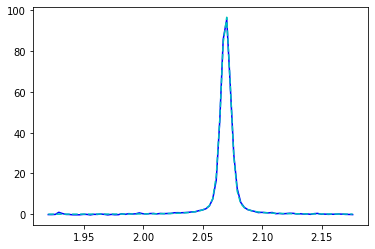

In [12]:
#  Do Curve Fitting of Initial Frame (assumes if light is on, new composition)
if light_on:
    image = 0 #index of file you want to look at
p0 = [0.2, 300, 2, .01] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
upper_limit = [1, 3000, q_2, 5]
lower_limit = [0, 0, q_1, 0]
popt,pcov = curve_fit(pvoigt, q_sub, perov_fit[:,image], p0, bounds=(lower_limit, upper_limit), maxfev=6000)
plt.plot(q_sub,perov_fit[:,image],'b-', label='Data') #plot subfield of data
plt.plot(q_sub,pvoigt(q_sub, *popt),'c--', label='Model') #plot best fit
init_q = popt[2] #this is the inital peak position that will be used as a reference
FWHM = popt[3] 

In [13]:
# %% Dynamics of Process
#  Plot Integrated Intensity over time
totalintensity = np.zeros(files)
for frame in range(files):
    totalintensity[frame] = sum(perov_fit[:,frame])

Text(0, 0.5, 'Integrated Intensity [Normalized]')

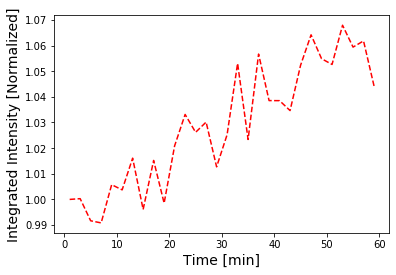

In [14]:
plt.plot(time, totalintensity/totalintensity[0], 'r--')
plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Integrated Intensity [Normalized]',size=14)#Define y-axis label

In [15]:
# Plot Binned Intenisty
iod_bin = np.zeros(files)
orig_bin = np.zeros(files)
brom_bin = np.zeros(files)

In [16]:
iod_lim = find_nearest(q_sub, init_q-FWHM)
brom_lim = find_nearest(q_sub, init_q+FWHM)

In [17]:
for frame in range(files):
    iod_bin[frame] = sum(perov_fit[0:iod_lim,frame])
    orig_bin[frame] = sum(perov_fit[iod_lim:brom_lim,frame])
    brom_bin[frame] = sum(perov_fit[brom_lim:,frame])

Text(0.5, 1.0, 'C1 Binned Intensity Dynamics')

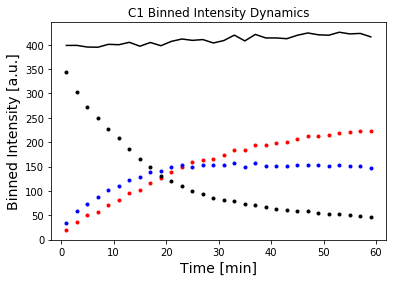

In [18]:
plt.plot(time, iod_bin, 'r.')
plt.plot(time, orig_bin, 'k.')
plt.plot(time, brom_bin, 'b.')
plt.plot(time, brom_bin+iod_bin+orig_bin, 'k-')

plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Binned Intensity [a.u.]',size=14)#Define y-axis label
plt.title('C1 Binned Intensity Dynamics')

In [19]:
# %% Save Variables
samplelist.append(samplename) #creates a list of the samples you've looked at this session
datatostore = [time, totalintensity, iod_bin, orig_bin, brom_bin] #creates a list of relevant data
results[samplename] = datatostore #adds an item to a dictionary where the sample name is linked to these results
print(samplelist)

['lighton_c1']


In [ ]:
##first fitting attempt--writing function
##gives single value instead of fit

In [20]:
##ionic transport (light on)
def ionfunc(x, a, g, t, r):
    return a*np.exp(g/(2*t*r))



In [21]:
#ion transport orig bin
p0 = [1,10^-3,300,8]


popt, pcov = curve_fit(ionfunc, time, orig_bin, p0, maxfev=8000)
orig_ion = ionfunc(time, *popt)
#orig_ion=np.array([ionfunc(time, *popt)])
print(orig_ion) ##should be array w/ shape (30,) but prints only single value

122.20157290222761


In [22]:
#ion transport iodine bin
p0 = [1,10^-6,300,8]

popt, pcov = curve_fit(ionfunc, time, iod_bin, p0)

iod_ion=np.array([ionfunc(time, *popt)])
print(iod_ion) ##should be array w/ shape (30,) but prints only single value

[153.22718579]


In [23]:
#ion transport bromine bin
p0 = [1,10^-6,300,8]

popt, pcov = curve_fit(ionfunc, time, brom_bin, p0)

brom_ion=np.array([ionfunc(time, *popt)])
print(brom_ion) ##should be array w/ shape (30,) but prints only single value

[134.66689802]


In [36]:
##second fitting attempt--lmfit Exponential Model
##works great for decay (orig bin) but can't figure out how to accurately model 
##growth (br and i regions)

In [24]:
pip install lmfit

Note: you may need to restart the kernel to use updated packages.


       x
0    1.0
1    3.0
2    5.0
3    7.0
4    9.0
5   11.0
6   13.0
7   15.0
8   17.0
9   19.0
10  21.0
11  23.0
12  25.0
13  27.0
14  29.0
15  31.0
16  33.0
17  35.0
18  37.0
19  39.0
20  41.0
21  43.0
22  45.0
23  47.0
24  49.0
25  51.0
26  53.0
27  55.0
28  57.0
29  59.0
<class 'pandas.core.frame.DataFrame'>
             y
0   343.872970
1   303.318083
2   272.881152
3   249.550483
4   227.417324
5   208.461916
6   186.648651
7   165.571548
8   148.237079
9   130.547373
10  119.636069
11  110.190428
12  100.725510
13   93.483011
14   86.098213
15   81.070104
16   78.294888
17   73.635540
18   70.231558
19   67.384320
20   63.736808
21   60.834896
22   59.578691
23   57.731924
24   54.730716
25   53.003188
26   52.342720
27   50.998790
28   48.841499
29   46.988499
<class 'pandas.core.frame.DataFrame'>


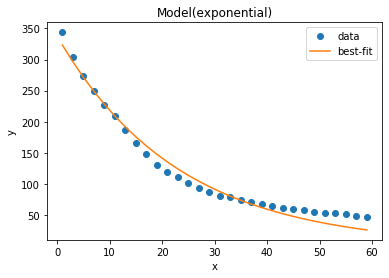

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 30
    # variables        = 2
    chi-square         = 4544.63656
    reduced chi-square = 162.308449
    Akaike info crit   = 154.615170
    Bayesian info crit = 157.417564
[[Variables]]
    amplitude:  337.616933 +/- 7.76618933 (2.30%) (init = 278.8456)
    decay:      22.9486141 +/- 0.78714193 (3.43%) (init = 29.36963)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay) = -0.726


In [33]:
from lmfit.models import ExponentialModel
model= ExponentialModel()

df_time = pd.DataFrame(time, columns = ['x'])

print(df_time)
print(type(df_time))

df_orig = pd.DataFrame(orig_bin, columns = ['y'])

print(df_orig)
print(type(df_orig))

params = model.guess(df_orig['y'], x=df_time['x'])

result = model.fit(df_orig['y'], params, x=df_time['x'])

result_orig=result

result_orig.plot_fit()
plt.show()

print(result_orig.fit_report())

             y
0    34.773408
1    59.657635
2    72.090921
3    88.142755
4   101.546407
5   110.502303
6   123.043573
7   128.616699
8   139.385961
9   141.228926
10  149.388183
11  152.912673
12  149.930378
13  153.620143
14  152.282660
15  154.063840
16  157.068562
17  149.971798
18  156.339426
19  151.877987
20  151.521126
21  150.871571
22  152.839334
23  152.726034
24  152.540391
25  150.878147
26  153.861427
27  150.380098
28  150.694795
29  147.240804
<class 'pandas.core.frame.DataFrame'>


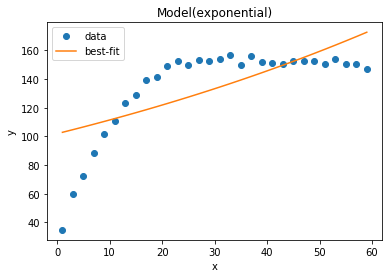

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 30
    # variables        = 2
    chi-square         = 15057.5206
    reduced chi-square = 537.768591
    Akaike info crit   = 190.553064
    Bayesian info crit = 193.355459
[[Variables]]
    amplitude:  101.949936 +/- 7.34194338 (7.20%) (init = 86.05594)
    decay:     -111.956753 +/- 23.1045326 (20.64%) (init = -74.32466)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay) = -0.902


In [39]:
model= ExponentialModel()

df_time = pd.DataFrame(time, columns = ['x'])


df_brom = pd.DataFrame(brom_bin, columns = ['y'])

print(df_brom)
print(type(df_brom))

params = model.guess(df_brom['y'], x=df_time['x'])

result = model.fit(df_brom['y'], params, x=df_time['x'])

result_brom=result

result_brom.plot_fit()
plt.show()

print(result_brom.fit_report())

             y
0    19.907103
1    35.693885
2    50.260165
3    57.206083
4    71.877674
5    81.073989
6    95.273567
7   102.799844
8   116.988170
9   126.192909
10  137.861452
11  148.657975
12  158.327243
13  163.474616
14  165.237252
15  173.478871
16  184.339332
17  184.265333
18  194.575273
19  194.654888
20  198.647876
21  200.656177
22  206.986882
23  213.681499
24  213.156345
25  215.651918
26  219.425206
27  220.852350
28  223.655669
29  221.960326
<class 'pandas.core.frame.DataFrame'>


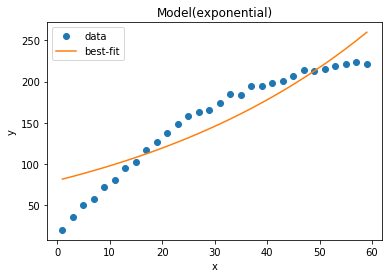

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 30
    # variables        = 2
    chi-square         = 19132.4493
    reduced chi-square = 683.301761
    Akaike info crit   = 197.738311
    Bayesian info crit = 200.540706
[[Variables]]
    amplitude:  79.9876867 +/- 6.73620228 (8.42%) (init = 54.21863)
    decay:     -50.0649712 +/- 4.83259165 (9.65%) (init = -33.14445)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay) = -0.938


In [40]:
model= ExponentialModel()

df_time = pd.DataFrame(time, columns = ['x'])


df_iod = pd.DataFrame(iod_bin, columns = ['y'])

print(df_iod)
print(type(df_iod))

params = model.guess(df_iod['y'], x=df_time['x'])

result = model.fit(df_iod['y'], params, x=df_time['x'])

result_iod=result

result_iod.plot_fit()
plt.show()

print(result_iod.fit_report())

Text(0.5, 1.0, 'C1 Binned Intensity Dynamics')

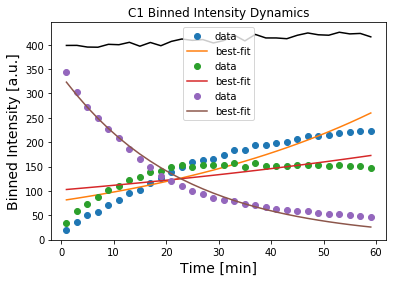

In [42]:
#plt with models
plt.plot(time, iod_bin, 'r.')
plt.plot(time, orig_bin, 'k.')
plt.plot(time, brom_bin, 'b.')
plt.plot(time, brom_bin+iod_bin+orig_bin, 'k-')
#plt.plot(time, ionfunc(time,*popt), 'k-', label='Model')
result_iod.plot_fit()
result_brom.plot_fit()
result_orig.plot_fit()

plt.xlabel('Time [min]',size=14) #Define x-axis label
plt.ylabel('Binned Intensity [a.u.]',size=14)#Define y-axis label
plt.title('C1 Binned Intensity Dynamics')

In [ ]:
###Having trouble selecting model to use for diffusion 
##assuming 2nd order ODE??
##thus, struggling to either write function or use pydiffusion

In [ ]:
##diffusion (light off)
##would be used to fit other c1 dataset 

#need to decide between Fick's 2nd Law, Arrhenius diffusion, or other

#def difffunc(x, other params ):
    #return funct

#popt, pcov = curve_fit(difffunc, x, y)